In [2]:
import pandas as pd
import numpy as np
import glob
import pickle as pkl

pd.set_option('display.max_columns', None)

# Carregando dados

In [13]:
folds = glob.glob("folds/*")

for i, fold in enumerate(folds):
    with open(fold, "rb") as f:
        fold_dict = pkl.load(f)

    X_test = fold_dict["X_test"]
    X_train = fold_dict["X_train"]
    y_test = fold_dict["y_test"]
    y_train = fold_dict["y_train"]

    if i == 0:
        global_X_test = X_test
        global_X_train = X_train
        global_y_test = y_test
        global_y_train = y_train

    else:
        global_X_test = pd.concat([global_X_test,X_test],axis=0)
        global_X_train = pd.concat([global_X_train,X_train],axis=0)
        global_y_test = np.hstack((global_y_test,y_test))
        global_y_train = np.hstack((global_y_train,y_train))

global_X = pd.concat([global_X_train,global_X_test],axis=0)
global_y = np.hstack((global_y_train,global_y_test)).tolist()

target_df = pd.DataFrame({
    "target": global_y
},index = global_X.index)

df = pd.concat([global_X,target_df],axis=1)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92935 entries, 0 to 18586
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   idade               92935 non-null  float64
 1   uf_AC               92935 non-null  float64
 2   uf_AL               92935 non-null  float64
 3   uf_AM               92935 non-null  float64
 4   uf_BA               92935 non-null  float64
 5   uf_CE               92935 non-null  float64
 6   uf_DF               92935 non-null  float64
 7   uf_ES               92935 non-null  float64
 8   uf_GO               92935 non-null  float64
 9   uf_MA               92935 non-null  float64
 10  uf_MG               92935 non-null  float64
 11  uf_MS               92935 non-null  float64
 12  uf_MT               92935 non-null  float64
 13  uf_PA               92935 non-null  float64
 14  uf_PB               92935 non-null  float64
 15  uf_PE               92935 non-null  float64
 16  uf_P

# Predição de óbito

## Correlação de Pearson

In [49]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Compute the correlation matrix
corr = df.corr().fillna(0)

corr_abs = ((corr) ** 2) ** 0.5

corr_df = pd.concat([corr.target, corr_abs.target], axis=1)

corr_df.columns = ["real", "abs"]

corr_df = corr_df.sort_values(by=["abs"], ascending=False)

best_corr_df = corr.loc[corr_df.index[:11], corr_df.index[:11]]

best_corr_df.columns = [
    "Target",
    "Age",
    "Origin state SP",
    "State SP",
    "State RJ",
    "Origin state RJ",
    "State SC",
    "State ES",
    "Origin state ES",
    "Origin state SC",
    "State PE",
]

best_corr_df.index = [
    "Target",
    "Age",
    "Origin state SP",
    "State SP",
    "State RJ",
    "Origin state RJ",
    "State SC",
    "State ES",
    "Origin state ES",
    "Origin state SC",
    "State PE",
]

best_corr_df

,Target,Age,Origin state SP,State SP,State RJ,Origin state RJ,State SC,State ES,Origin state ES,Origin state SC,State PE
Target,1.000000,-0.308106,-0.250155,-0.228646,0.126216,0.121295,0.108887,-0.104950,-0.099500,0.098788,0.097980
Age,-0.308106,1.000000,0.170825,0.138133,-0.039923,-0.034995,-0.014820,0.023048,0.016735,-0.019952,-0.051333
Origin state SP,-0.250155,0.170825,1.000000,0.918325,-0.188954,-0.209136,-0.143274,-0.145371,-0.144020,-0.153897,-0.180611
State SP,-0.228646,0.138133,0.918325,1.000000,-0.204142,-0.203165,-0.163481,-0.157056,-0.147267,-0.164461,-0.195128
State RJ,0.126216,-0.039923,-0.188954,-0.204142,1.000000,0.901416,-0.041798,-0.040155,-0.036849,-0.042510,-0.049889
Origin state RJ,0.121295,-0.034995,-0.209136,-0.203165,0.901416,1.000000,-0.044983,-0.043116,-0.044031,-0.047050,-0.055217
State SC,0.108887,-0.014820,-0.143274,-0.163481,-0.041798,-0.044983,1.000000,-0.032157,-0.031858,0.924100,-0.039952
State ES,-0.104950,0.023048,-0.145371,-0.157056,-0.040155,-0.043116,-0.032157,1.000000,0.960834,-0.032705,-0.038382
Origin state ES,-0.099500,0.016735,-0.144020,-0.147267,-0.036849,-0.044031,-0.031858,0.960834,1.000000,-0.032401,-0.038025
Origin state SC,0.098788,-0.019952,-0.153897,-0.164461,-0.042510,-0.047050,0.924100,-0.032705,-0.032401,1.000000,-0.040633


<AxesSubplot: >

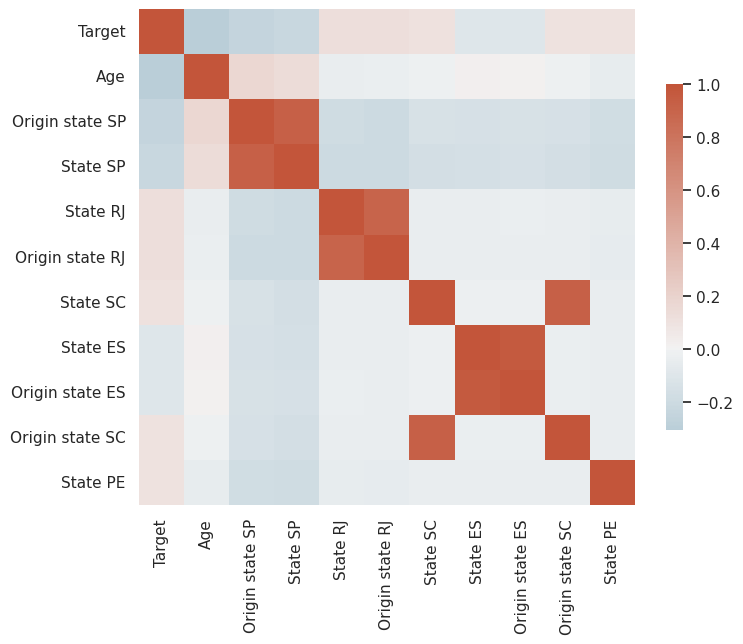

In [50]:
# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(best_corr_df, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    best_corr_df,
    # mask=mask,
    cmap=cmap,
    center=0,
    square=True,
    # linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    # xticklabels=False,
    # yticklabels=False,
)

In [24]:
corr_abs = ((corr.fillna(0)) ** 2) ** 0.5
pd.DataFrame(
    {
        "Atributo": corr_abs.transplante_bin.sort_values(ascending=False).index,
        "Correlação": corr_abs.transplante_bin.sort_values(ascending=False).values,
    }
).head(13)

,Atributo,Correlação
0,transplante_bin,1.000000
1,uf_origem_SP,0.205467
2,uf_SP,0.183702
3,uf_ES,0.108635
4,uf_origem_ES,0.101357
5,uf_RJ,0.088028
6,uf_origem_RJ,0.086067
7,uf_SC,0.073736
8,uf_origem_SC,0.068797
9,uf_PE,0.067854


## PCA

Total explained variance ratio: 0.43816064819768785


Text(0.5, 0.92, 'Projeção com os 3 primeiros componentes')

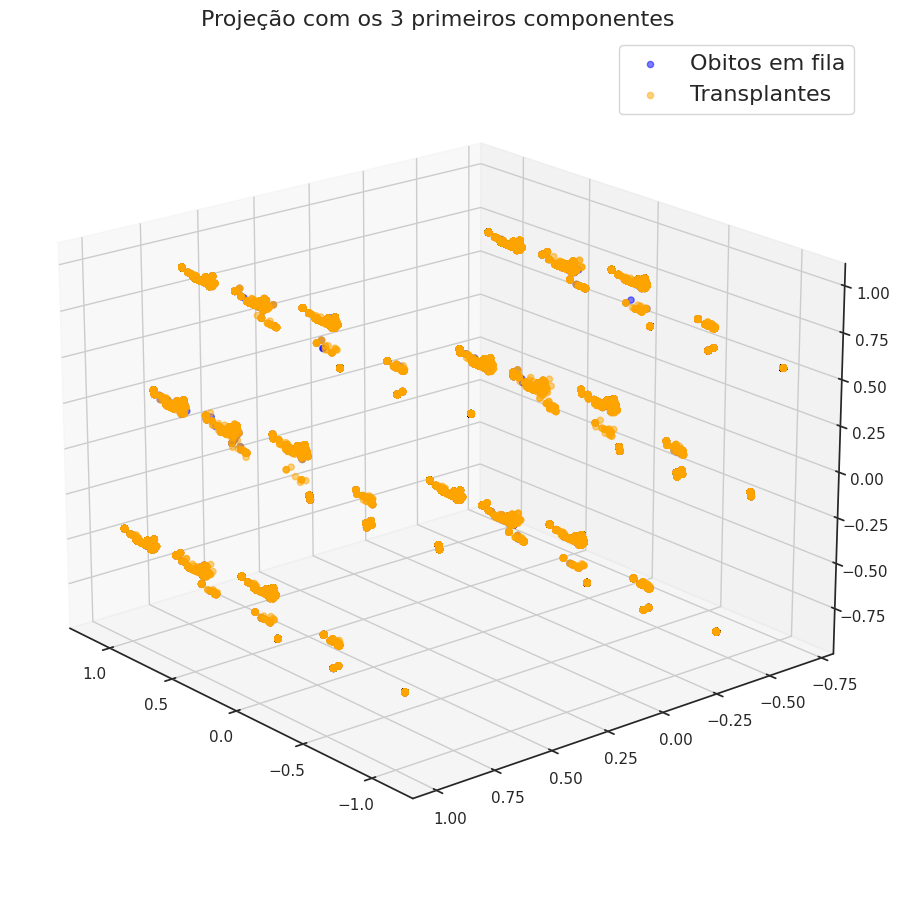

In [35]:
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(9, 9))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=20, azim=140)
ax.set_position([0, 0, 0.95, 1])

X = df_obito.drop(columns=["transplante_bin"])

pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)

print("Total explained variance ratio: %s" % str(sum(pca.explained_variance_ratio_)))

target_names = ["Óbito em fila", "Transplante"]
lw = 1


ax.scatter(
    X_r[df_obito["transplante_bin"] == 0, 0],
    X_r[df_obito["transplante_bin"] == 0, 1],
    X_r[df_obito["transplante_bin"] == 0, 2],
    alpha=0.5,
    color="blue",
    lw=lw,
    label="Obitos em fila",
)

ax.scatter(
    X_r[df_obito["transplante_bin"] == 1, 0],
    X_r[df_obito["transplante_bin"] == 1, 1],
    X_r[df_obito["transplante_bin"] == 1, 2],
    alpha=0.5,
    color="orange",
    lw=lw,
    label="Transplantes",
)


ax.legend(loc="best", shadow=False, scatterpoints=1, fontsize=16)
ax.set_title("Projeção com os 3 primeiros componentes", fontsize=16)

Total explained variance ratio: 0.4381606481976875


Text(0.5, 0.92, 'Projeção com os 3 primeiros componentes')

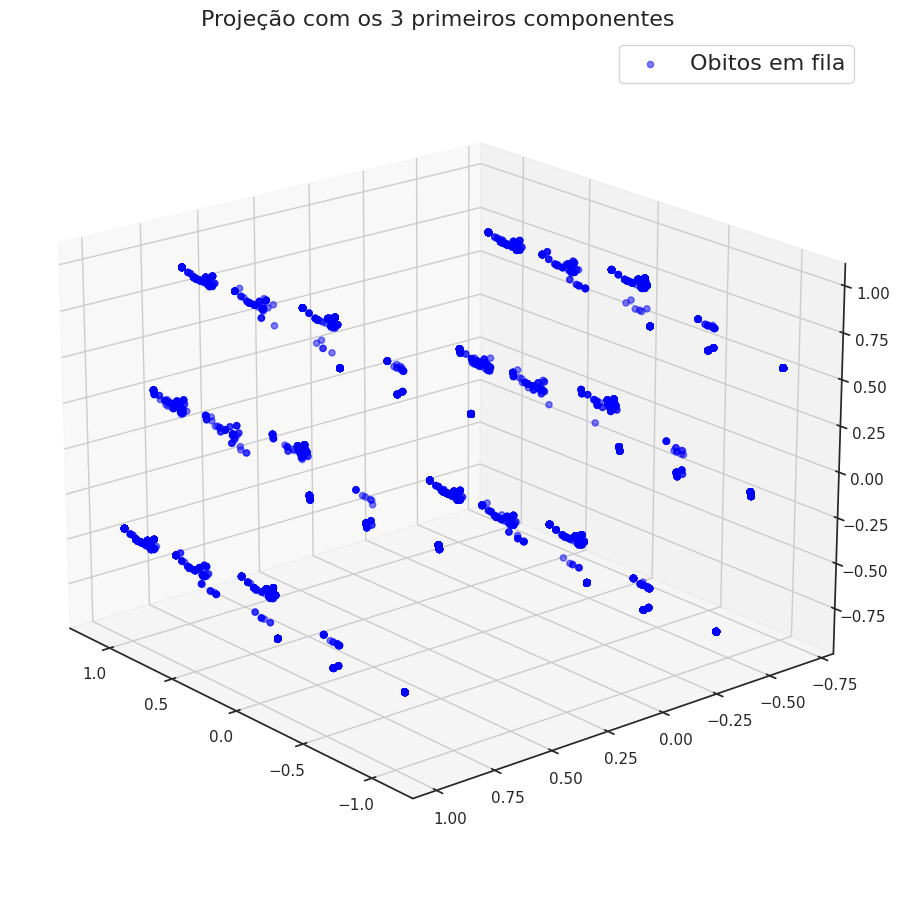

In [36]:
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(9, 9))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=20, azim=140)
ax.set_position([0, 0, 0.95, 1])

X = df_obito.drop(columns=["transplante_bin"])

pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)

print("Total explained variance ratio: %s" % str(sum(pca.explained_variance_ratio_)))

target_names = ["Óbito em fila", "Transplante"]
lw = 1


ax.scatter(
    X_r[df_obito["transplante_bin"] == 0, 0],
    X_r[df_obito["transplante_bin"] == 0, 1],
    X_r[df_obito["transplante_bin"] == 0, 2],
    alpha=0.5,
    color="blue",
    lw=lw,
    label="Obitos em fila",
)

# ax.scatter(
#     X_r[df_obito["transplante_bin"] == 1, 0],
#     X_r[df_obito["transplante_bin"] == 1, 1],
#     X_r[df_obito["transplante_bin"] == 1, 2],
#     alpha=0.5,
#     color="orange",
#     lw=lw,
#     label="Transplantes",
# )


ax.legend(loc="best", shadow=False, scatterpoints=1, fontsize=16)
ax.set_title("Projeção com os 3 primeiros componentes", fontsize=16)

Total explained variance ratio: 0.4381606481976871


Text(0.5, 0.92, 'Projeção com os 3 primeiros componentes')

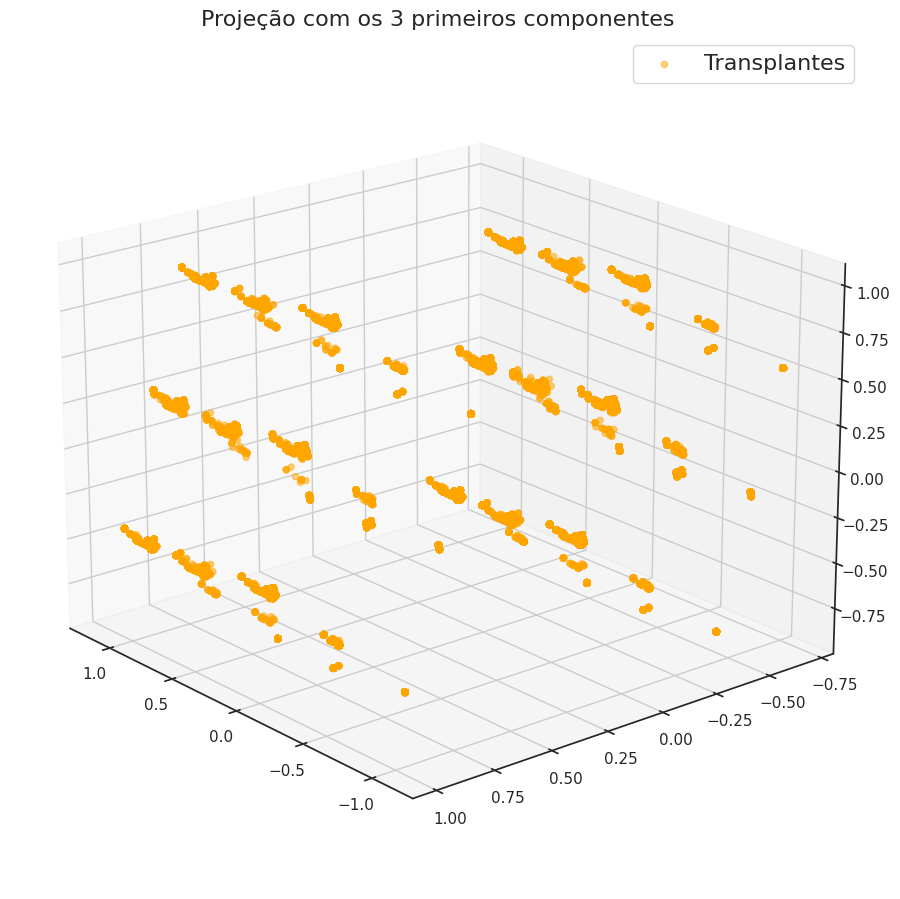

In [37]:
from sklearn.decomposition import PCA

fig = plt.figure(1, figsize=(9, 9))
plt.clf()

ax = fig.add_subplot(111, projection="3d", elev=20, azim=140)
ax.set_position([0, 0, 0.95, 1])

X = df_obito.drop(columns=["transplante_bin"])

pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)

print("Total explained variance ratio: %s" % str(sum(pca.explained_variance_ratio_)))

target_names = ["Óbito em fila", "Transplante"]
lw = 1


# ax.scatter(
#     X_r[df_obito["transplante_bin"] == 0, 0],
#     X_r[df_obito["transplante_bin"] == 0, 1],
#     X_r[df_obito["transplante_bin"] == 0, 2],
#     alpha=0.5,
#     color="blue",
#     lw=lw,
#     label="Obitos em fila",
# )

ax.scatter(
    X_r[df_obito["transplante_bin"] == 1, 0],
    X_r[df_obito["transplante_bin"] == 1, 1],
    X_r[df_obito["transplante_bin"] == 1, 2],
    alpha=0.5,
    color="orange",
    lw=lw,
    label="Transplantes",
)


ax.legend(loc="best", shadow=False, scatterpoints=1, fontsize=16)
ax.set_title("Projeção com os 3 primeiros componentes", fontsize=16)